In [1]:
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import networkx as nx
from pyproj import CRS
from scipy import stats
import math

# Leemos datos de crimenes

In [3]:
file_path = './crimes_datasets/assault_november_december.csv'
crime_data = pd.read_csv(file_path)

len(crime_data)

2320

# Empaquetamos en un geodataframe

In [4]:
gdf_crime_data = gpd.GeoDataFrame(crime_data, geometry=gpd.points_from_xy(crime_data['X'], crime_data['Y']), crs='EPSG:4326') 
gdf_crime_data_projected = gdf_crime_data.to_crs('EPSG:7131')

# Generamos el modelo de scipy

In [5]:
latlon_projection = np.array([[point.x,point.y] for point in gdf_crime_data_projected.geometry])
kernel_scipy = stats.gaussian_kde(latlon_projection.T)

# Obtenemos el grafo de Philadelphia

In [6]:
filename_3857 = "./grafos_3857/sf_scored_3857.graphml"
phil_streets_data = ox.load_graphml(filename_3857)
nodes, edges = ox.graph_to_gdfs(phil_streets_data)

In [7]:
edge_ids = list(phil_streets_data.edges)
for edge_id in edge_ids:
    if edge_id[2] != 0:
        phil_streets_data.remove_edge(*edge_id)  

# Proyectamos los geodataframes

In [8]:
nodes = nodes.to_crs(epsg=7131)
edges = edges.to_crs(epsg=7131)

# Primera fase del modelo de riesgo

In [9]:
non_normalized_risk_scores = []

for street in edges.geometry:
    street_coords = list(street.coords)
    risk_score = 0
    for coord in street_coords:
        risk_score += kernel_scipy(coord)
    non_normalized_risk_scores.append(risk_score)

non_normalized_risk_scores = np.array(non_normalized_risk_scores)
normalized_risk_scores = non_normalized_risk_scores / np.sum(non_normalized_risk_scores)

# Segunda fase del modelo de riesgo con los valores logaritmicos

In [10]:
log_normalized_risk_scores = []

for risk_score in normalized_risk_scores:
    log_risk_score = -1 * math.log(1 - risk_score, 10)
    log_normalized_risk_scores.append(log_risk_score)

# Generamos los scores en los geodataframes

In [11]:
edges["normalized_risk_scores"] = normalized_risk_scores
edges["log_normalized_risk_scores_new"] = log_normalized_risk_scores

# Generamos diccionarios para posteriormente setear pesos en el grafo

In [12]:
nx_risk_scores = {}
nx_log_risk_scores = {}
for index, row  in edges.iterrows():
    nx_risk_scores[index] = row.normalized_risk_scores
    nx_log_risk_scores[index] = row.log_normalized_risk_scores_new

# Seteamos los scores de riesgo para usos posteriores

In [13]:
nx.set_edge_attributes(phil_streets_data, nx_risk_scores, 'risk_score')
nx.set_edge_attributes(phil_streets_data, nx_log_risk_scores, 'log_risk_score_new')

# Ploteamos

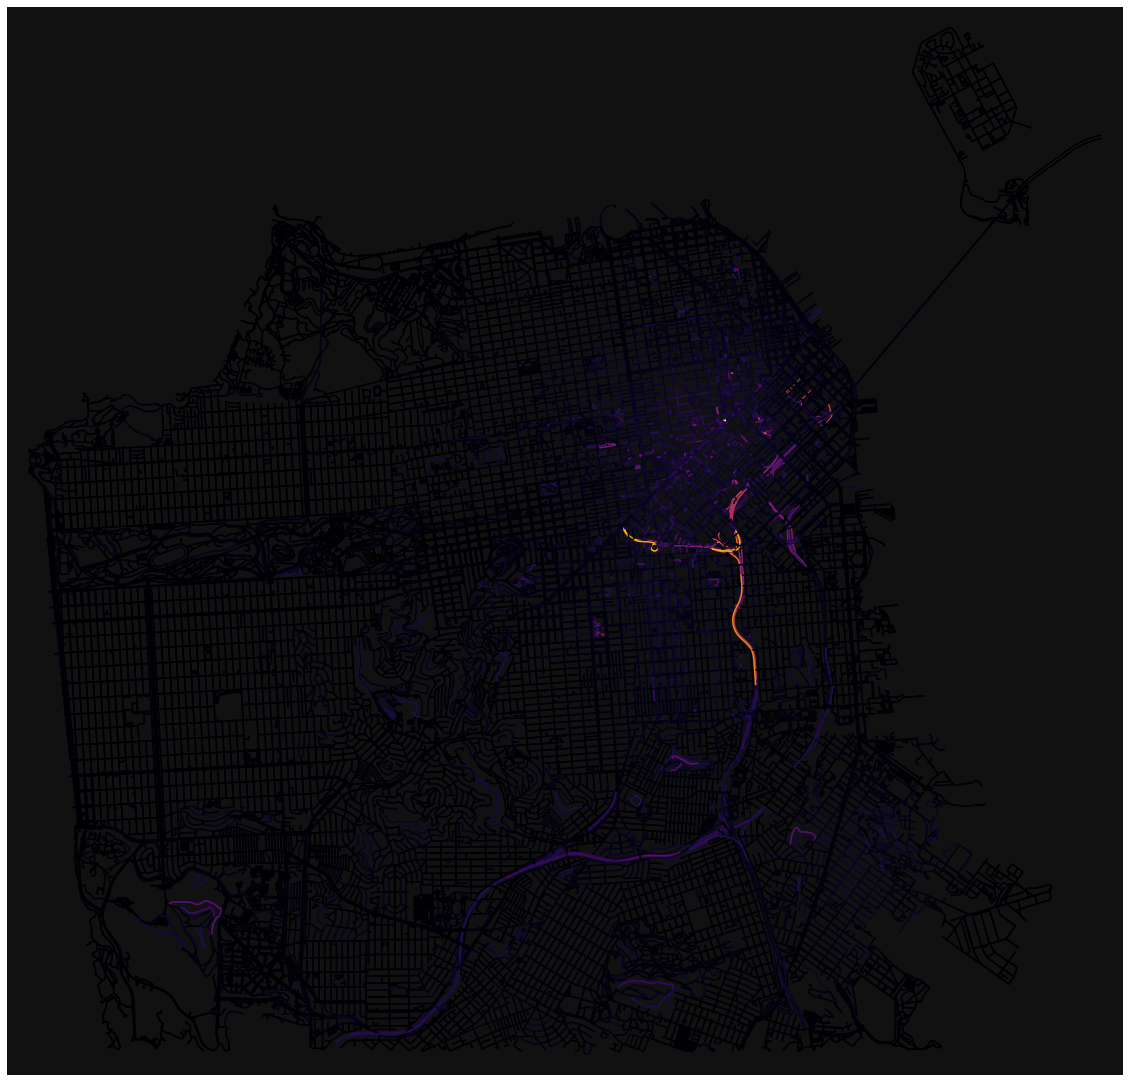

In [14]:
edge_color_by_log = ox.plot.get_edge_colors_by_attr(phil_streets_data, 
                                             'log_risk_score_new', 
                                             cmap='inferno', 
                                             start=0.001
                                            )

fig, ax = ox.plot_graph(phil_streets_data, 
                        edge_color=edge_color_by_log, 
                        edge_linewidth=1.5, 
                        node_size=0, 
                        figsize=(20, 20), 
                        bgcolor='#111111',
                       )

In [15]:
phil_streets_data_proj = ox.project_graph(phil_streets_data, to_crs='epsg:7131')

In [16]:
ox.save_graphml(phil_streets_data_proj, "./grafos_puntuados/san_francisco_graph_scored_epsg7131.graphml")

# Generando el archivo de aristas para Java

In [25]:
edges_proj = ox.graph_to_gdfs(phil_streets_data_proj, nodes=False, edges=True)
edges_proj

osmid  \
u          v          key                                                
32927563   645559609  0               [50690291, 179235221, 661905446]   
645559609  65285375   0    [839972872, 255330064, 11414754, 255330063]   
           1792813400 0      [52527662, 237731428, 52721870, 50691047]   
65285375   65339909   0                                      255330058   
1792813400 2456072718 0                                      237731428   
...                                                                ...   
8948977070 8948977065 0              [967290673, 967290674, 967290675]   
8995374247 8995374240 0                                      971901557   
           8995374245 0                         [971901556, 971901557]   
8995374245 8995374240 0                         [971901555, 971901556]   
           8995374247 0                         [971901556, 971901557]   

                           oneway lanes   ref  \
u          v          key                       
32927563   645559609  0      True     5  I 80   
645559609  65285375   0      True     1   NaN   
           1792813400 0      True     5  I 80   
65285375   65339909   0      True   NaN   NaN   
1792813400 2456072718 0      True     5  I 80   
...                           ...   ...   ...   
8948977070 8948977065 0     False   NaN   NaN   
8995374247 8995374240 0     False   NaN   NaN   
           8995374245 0     False   NaN   NaN   
8995374245 8995374240 0     False   NaN   NaN   
           8995374247 0     False   NaN   NaN   

                                                         name  \
u          v          key                                       
32927563   645559609  0    San Francisco – Oakland Bay Bridge   
645559609  65285375   0                                   NaN   
           1792813400 0    San Francisco – Oakland Bay Bridge   
65285375   65339909   0                  Treasure Island Road   
1792813400 2456072718 0    San Francisco – Oakland Bay Bridge   
...                                                       ...   
8948977070 8948977065 0                                   NaN   
8995374247 8995374240 0                                   NaN   
           8995374245 0                                   NaN   
8995374245 8995374240 0                                   NaN   
           8995374247 0                                   NaN   

                                    highway          maxspeed    length  \
u          v          key                                                 
32927563   645559609  0            motorway            50 mph  3232.712   
645559609  65285375   0       motorway_link            50 mph   398.655   
           1792813400 0            motorway  [40 mph, 50 mph]   728.696   
65285375   65339909   0            tertiary            15 mph    24.865   
1792813400 2456072718 0            motorway            50 mph  1223.413   
...                                     ...               ...       ...   
8948977070 8948977065 0    [steps, footway]               NaN    31.164   
8995374247 8995374240 0             service               NaN    21.955   
           8995374245 0             service               NaN   121.110   
8995374245 8995374240 0             service               NaN   102.741   
           8995374247 0             service               NaN   121.110   

                          bridge  \
u          v          key          
32927563   645559609  0      yes   
645559609  65285375   0      yes   
           1792813400 0      yes   
65285375   65339909   0      NaN   
1792813400 2456072718 0      yes   
...                          ...   
8948977070 8948977065 0      NaN   
8995374247 8995374240 0      NaN   
           8995374245 0      NaN   
8995374245 8995374240 0      NaN   
           8995374247 0      NaN   

                                                                    geometry  \
u          v          key                                                      
32927563   64

In [31]:
alert = False

for index, row in edges_proj.iterrows():
    if index[2] != 0:
        alert = True
        break
        
if not alert:
    print("Exito")

Exito


In [32]:
edges_list_data = []

c1_name="length"
c2_name="log_risk_score_new"

columns_csv = [
    "from",
    "to",
    c1_name,
    c2_name
]

for index, edge in edges_proj.iterrows():
    if index[2] == 0:
        edges_list_data.append([index[0],index[1],edge[c1_name], edge[c2_name]])
    else:
        print("aggggggggggggggg")
        
edges_df = pd.DataFrame.from_records(edges_list_data, columns=columns_csv)
edges_df.to_csv("./grafos_para_java/sf_edges_data_7131.csv", index=False)